In [22]:
#Formatting:
%matplotlib notebook

#Import required packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve

In [165]:
#Create a class for calculating the pitzer equations, using empirically determined Pitzer parameters from the literature.
class PitzerEqns:
    def __init__(self, MW:float, nu:tuple, z:tuple, B0_params:tuple, B1_params:tuple, \
                 Cphi_params:tuple, T_eu:float, ):
        #Parameters specific to the system
        self.MW = MW #Molecular weight of salt, in kg/mol
        self.nu = nu #Moles of (cation, anion) per mole of salt
        self.z = z #Charge of (cation, anion)
        self.B0_params = B0_params #Pitzer ionic constants
        self.B1_params = B1_params
        self.Cphi_params = Cphi_params
        self.T_eu = T_eu

    #Convert between weight % and molal for a given Molecular Weight (kg/mol)
    def wp2molal(self, wtperc):
        return 1/self.MW*(wtperc/(1-wtperc))
    def molal2wp(self, molal):
        return self.MW*molal/(1+self.MW*molal)
               
    #Ionic strength from salt molal, moles of ions, and ion charges
    def get_Is(self,m_salt): 
        mi_zi2 = 0
        for i in range(len(self.z)):
            mi_zi2 += m_salt*self.nu[i]*self.z[i]**2 #sum recursively over all ions & concentrations
        I = 0.5*mi_zi2       
        return I   

    def sum_mi(self,m_salt): #sum over molalities of all species
        sum_mi = 0
        for j in range(len(self.nu)):
            sum_mi += self.nu[j]*m_salt
        return sum_mi
        
    def get_P(self,T, ABC): #Find Pitzer parameter P (where P is any of: Beta0, Beta1, or Cphi) based on parameters A, B, C
        A,B,C = ABC #Split up A,B,C parameters    
        P = ( A + B*(T - 298.15) +C*(T - 298.15)**2 )  #Eqn 16 in toner+ 2015
        return P
        
    def get_Bphi(self,m_salt,T):
        alpha = (2,0) #alpha equals 2 for 1-1- or 2-1- salts! It also works for 3-1- and 4-1- salts too. However, it does NOT work for 2-2 type salts!
        if self.nu == (2,2):
            raise ValueError('This model does not work for 2-2 type salts! Please only use for 1-1 or 2-1 type salts. 3-1 and 4-1 type salts should also work, but have not been tested.')
        
        Is = self.get_Is(m_salt)
        B0 = self.get_P(T,self.B0_params)
        B1 = self.get_P(T,self.B1_params)
        
        Bphi = B0 + B1 * np.exp(-alpha[0] * np.sqrt(Is)) 
        
        return Bphi
    
    def get_C(self,T):
        Cphi = self.get_P(T,self.Cphi_params)
        C = Cphi / (2 * np.sqrt(abs(self.z[0]*self.z[1])))
        return C
    
    #Calculate osmotic coefficient (Phi)
    def get_Phi(self,m_salt,T):
        Aphi = 0.13422*(0.0368329*T - 14.62718*np.log(T) - 1530.1474/T + 80.40631) #Debye Huckle limiting slope. Equation from (Chevrier+, 2009)
        b = 1.2 #Universal parameter. Units kg^(1/2) * mol^(-)
        Is = self.get_Is(m_salt)
        sum_mi = self.sum_mi(m_salt)
        Bphi = self.get_Bphi(m_salt,T)
        C = self.get_C(T)
        
        Z = self.nu[0]*m_salt * abs(self.z[0]) + self.nu[1]*m_salt * abs(self.z[1])
        
        Phi = 1 + 2 / sum_mi * \
            ( -Aphi * Is**(3/2) / (1 + b*np.sqrt(Is)) + \
             self.nu[0]*m_salt * self.nu[1]*m_salt * (Bphi + Z*C ) )
    
        return Phi
    
    def get_aw_Phi(self,m_salt,T): #Calculate aw from osmotic coefficient and molal of salt {Pitzer, 1991; Eqn 28}
        sum_mi = self.sum_mi(m_salt)
        Phi = self.get_Phi(m_salt,T)
        aw = np.exp( -Phi * sum_mi / 55.50844) #55.5 is moles per kilogram of H2O 
        return aw
    
    def get_aw_ice(self,T): #Calculate aw(T) at the freezing point of ice. Based on FREEZCHEM equation (Marion & Kargel, 2008)
        aw = 1.906354 - (1.880285e-2 * T) + (6.603001e-5 * T**2) - (3.419967e-8 * T**3)
        return aw
    
    #Calculate freezing temperature given molal concentration of salt:
    def get_Tf(self,m_salt):
        #We have 2 separate equations for aw(m_salt,T) and aw(T).
        #Given a concentration m, solve for the T such that aw(m,T) - aw(T) = 0
        Tf = fsolve( lambda T: abs(self.get_aw_Phi(m_salt,T) - self.get_aw_ice(T) ) , 200) #T0 = 200 is a good starting guess
        return Tf[0]
    
    #Calculate the eutectic concentration from the provided eutectic temperature.
    def m_eu(self,):
        return fsolve( lambda x: self.get_Tf(m_salt = x) - self.T_eu, x0 = 3)[0] #solves for the molal concentration that gives the correct eutectic temperature.

    
#Manually create instances for each salt you want to work with.
#Find relevant parameters in 'Pitzer Parameters Oxychlorine.xlsx,' or find your own from the literature!

#Create an instance for Sodium Perchlorate
Na_ClO4 = PitzerEqns(MW = 0.12244, #Molecular weight, in kg/mol
                    nu = (1,1), #Moles of (cation/anion) per mole of salt
                    z = (1,1), #Charge of cation, anion
                    B0_params = (5.5400e-02, 7.8712e-04, -3.8727e-06),
                    B1_params = (2.7550e-01, 4.4318e-03, -1.2331e-04),
                    Cphi_params = (-1.1800e-03 , -5.3394e-05, 3.9507e-07),
                    T_eu = 239.2 #Kelvin. From Toner+ 2015
                    )

#Create an instance for Calcium Perchlorate
Ca_ClO4 = PitzerEqns(MW = 0.23898, #Molecular weight, in kg/mol
                    nu = (1,2), #Moles of (cation/anion) per mole of salt
                    z = (2,1), #Charge of cation, anion
                    B0_params = (4.511300e-01, 3.976000e-04, 5.010300e-07),
                    B1_params = (1.756500, 0.007360, -0.000124),
                    Cphi_params = (-5.001000e-03 , -1.668200e-04, -5.995900e-07),
                    T_eu = 198.2 #Kelvin. From Toner+ 2015
                    )

#Create an instance for Magnesium Perchlorate
Mg_ClO4 = PitzerEqns(MW = 0.223206, #Molecular weight, in kg/mol
                  nu = (1,2), #Moles of (cation, anion) per mole of salt
                  z = (2,1), #Charge of (cation, anion)
                  B0_params = (0.49613, 0.00049397, -2.7085e-06),
                  B1_params = (2.0085, 0.0050772, -0.00042302),
                  Cphi_params = (0.009581, -0.00034602, -2.1062e-07),
                  T_eu = 209.5 #Kelvin. From Toner+ 2015
                  )

salts = {'NaClO4': Na_ClO4, 'Mg(ClO4)2': Mg_ClO4, 'Ca(ClO4)2': Ca_ClO4} #Define a new dictionary to make it easy to reference each salt model recursively.


# Below are some examples of how to use this model:

## 1) Plot freezing points for salts. Compare to experimental data to check model.

In [163]:
#Import experimental data from Toner 2015 to make sure the model is preforming correctly.
exp_fp = pd.read_excel('Experimental brine data_Toner+ 2015.xlsx', sheet_name=None, header=1)
salt_keys = list(exp_fp.keys()) #retrieve salt names (keys) for later

<IPython.core.display.Javascript object>


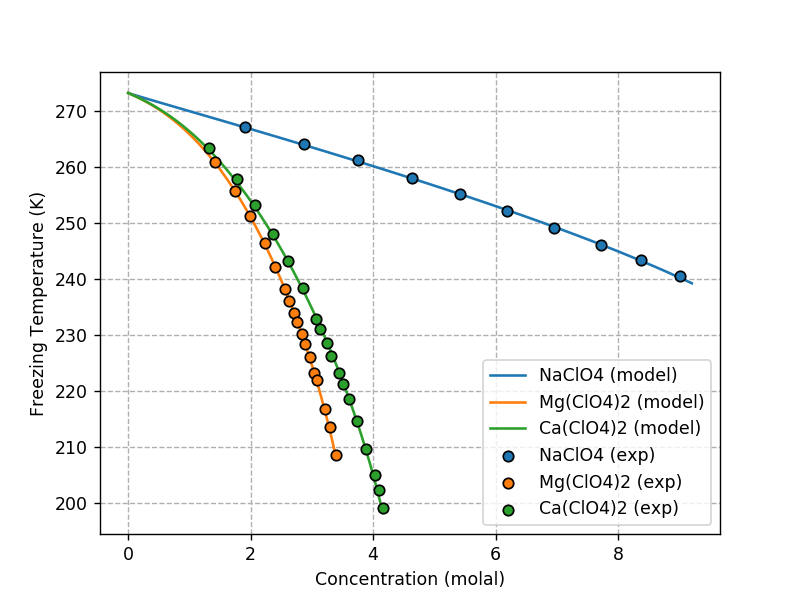

If everything is working properly, the model should match the experimental results above^


In [170]:
#Choose columns from 'exp_fp' dataframe that you want to plot.
x = 'Molal'
y = 'Temperature'

fig, ax = plt.subplots()

#For each salt type in the 'exp_fp' dataframe
for s in salt_keys:
    #Plot experimental data:
    xdata = exp_fp[s][x] 
    ydata = exp_fp[s][y]
    ax.scatter(xdata,ydata, label=s+' (exp)', edgecolor='k', zorder =2)
    
    #Plot model results:
    molals = np.linspace(1e-4, salts[s].m_eu(), 100) #List of molals from ~0 to the eutectic concentration. (Don't actually go to zero or you'll run into some infinity values.)
    Tf_list = []
    for mi in molals:
        Tf_list.append(salts[s].get_Tf(m_salt = mi))

    ax.plot(molals, Tf_list, label = s+' (model)', zorder=1)

#Formatting
ax.set_ylabel('Freezing Temperature (K)')
ax.set_xlabel('Concentration (molal)')
ax.grid(ls="--")
ax.set_axisbelow(True) #draw gridlines behind points.
ax.legend()
plt.show()

print('^If everything is working properly, the model should match the experimental results above^')

## 1) Plot the freezing temperature of Na- and Mg-Perchlorate with concentration:

## Example 2) Calculate the water activity and ionic strength at a given concentration:

In [212]:
#Mg(ClO4)2:
salt_name1 = 'Mg(ClO4)2'
m1 = 4.29 #molal
T1 = 298.15 #Kelvin
aw1 = Mg_ClO4.get_aw_Phi(m1, T1)
Is1 = Mg_ClO4.get_Is(m1)
print('{} at {} molal and {} K : aw = {:.3}, Ionic Strength = {}'.format(salt_name1, m1, T1, aw1, Is1))

#Ca(ClO4)2:
salt_name2 = 'Ca(ClO4)2'
m2 = 5.77 #molal
T2 = 298.15 #Kelvin
aw2 = Ca_ClO4.get_aw_Phi(m2, T2)
Is2 = Ca_ClO4.get_Is(m2)
print('{} at {} molal and {} K : aw = {:.3}, Ionic Strength = {}'.format(salt_name2, m2, T2, aw2, Is2))

#NaClO4:
salt_name3 = 'NaClO4'
m3 = 16.60 #molal
T3 = 298.15 #Kelvin
aw3 = Na_ClO4.get_aw_Phi(m3, T3)
Is3 = Na_ClO4.get_Is(m3)
print('{}    at {} molal and {} K : aw = {:.3}, Ionic Strength = {}'.format(salt_name3, m3, T3, aw3, Is3))

Mg(ClO4)2 at 4.29 molal and 298.15 K : aw = 0.429, Ionic Strength = 12.870000000000001
Ca(ClO4)2 at 5.77 molal and 298.15 K : aw = 0.324, Ionic Strength = 17.31
NaClO4    at 16.6 molal and 298.15 K : aw = 0.453, Ionic Strength = 16.6
